# Import necessary modules

In [1]:
!pip install -U imbalanced-learn

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

# Processing
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from imblearn.under_sampling import RandomUnderSampler

# gensim
import gensim
from gensim.models import Word2Vec

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, \
        f1_score, precision_score, recall_score

# Neural networks
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Embedding, Flatten
from keras.initializers import Constant
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils import plot_model

Requirement already up-to-date: imbalanced-learn in /opt/conda/lib/python3.6/site-packages (0.7.0)


Using TensorFlow backend.


# Handle Imbalanced Dataset

## Exploratory Data Analysis

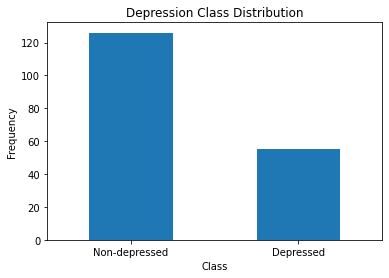

The ratio of negative to positive cases is 2.29.


In [2]:
df = pd.read_csv("../../data/clean_compiled_transcripts.csv")

count_classes = pd.value_counts(df.PHQ_Binary)
count_classes.plot(kind = 'bar', rot=0)
labels = ["Non-depressed", "Depressed"]

plt.title("Depression Class Distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

print(f"The ratio of negative to positive cases is {round(count_classes[0] / count_classes[1], 2)}.")

Clearly, the dataset is highly imbalanced and is likely to result in poor performance. We should strive for 50:50 during training.

## Convert transcripts to padded sequences

In [3]:
RANDOM_STATE = 42 # lucky number

X = df.Transcript
y = df.PHQ_Binary.to_numpy()

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
vocab_size = len(tokenizer.word_index) + 1

word_index = tokenizer.word_index
word_index

{'i': 1,
 'um': 2,
 'it': 3,
 'uh': 4,
 'you': 5,
 'my': 6,
 'know': 7,
 'like': 8,
 'me': 9,
 'really': 10,
 'would': 11,
 'yeah': 12,
 'think': 13,
 'they': 14,
 'people': 15,
 'well': 16,
 'good': 17,
 'we': 18,
 'things': 19,
 'get': 20,
 'lot': 21,
 'time': 22,
 'go': 23,
 'she': 24,
 'he': 25,
 'pretty': 26,
 'going': 27,
 'one': 28,
 'probably': 29,
 'them': 30,
 'little': 31,
 'life': 32,
 'something': 33,
 'say': 34,
 'could': 35,
 'mm': 36,
 'feel': 37,
 'guess': 38,
 'much': 39,
 'years': 40,
 'mean': 41,
 'different': 42,
 'yes': 43,
 'kinda': 44,
 'myself': 45,
 'back': 46,
 'want': 47,
 'oh': 48,
 'see': 49,
 'right': 50,
 'got': 51,
 'sometimes': 52,
 'her': 53,
 'always': 54,
 'went': 55,
 'hard': 56,
 'ago': 57,
 'work': 58,
 'okay': 59,
 'kind': 60,
 'school': 61,
 'try': 62,
 'family': 63,
 'maybe': 64,
 'love': 65,
 'actually': 66,
 'make': 67,
 'day': 68,
 'friends': 69,
 'happy': 70,
 'way': 71,
 'thing': 72,
 'anything': 73,
 'last': 74,
 'job': 75,
 'two': 76,
 

In [5]:
maxlen = 1000

def prepare(X):
    X_seq = tokenizer.texts_to_sequences(X)
    X_mat = sequence.pad_sequences(X_seq, maxlen=maxlen, padding='post')
    
    return X_mat

## Split the dataset 

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(prepare(X), y, test_size=0.2, random_state=RANDOM_STATE)

X_train_val.shape, X_test.shape

((144, 1000), (37, 1000))

### Undersampling
We will be using undersampling techniques instead of oversampling because we are not sure of the newly generated data points.

In [7]:
# the ratio of minority class to majority class will be 1 after resampling
us = RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE)

X_train_val, y_train_val = us.fit_sample(X_train_val, y_train_val)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=RANDOM_STATE)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((70, 1000), (18, 1000), (70,), (18,))

Now we have `X_train`, `X_val`, `X_test`, `y_train`, `y_val`, `y_test` ready to be used for model training, validation and testing.

# More preprocessing

## Evaluation metrics

In [8]:
def evaluate_on_training_set(y_test, y_pred):
    print(y_pred)
    print(y_test)
    
    # Calculate AUC
    print("AUC is: ", roc_auc_score(y_test, y_pred))

    # print out recall and precision
    print(classification_report(y_test, y_pred))

    # print out confusion matrix
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

    # # calculate points for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')

## Run model

In [9]:
class Metrics(Callback):

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(f" — val_f1: {_val_f1} — val_precision: {_val_precision} — val_recall: {_val_recall}")
        return

metrics = Metrics()

In [10]:
def train_NN(model, model_name):
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    checkpoint_filepath = f'{model_name}.h5'

    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True)

    model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val), callbacks=[checkpoint, metrics])
    loss, acc = model.evaluate(X_test, y_test)

    model = load_model(checkpoint_filepath)

    print('Test loss:', loss)
    print('Test accuracy:', acc)
    
    return model

# Custom Word Embeddings

## Naive Neural Networks

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 128)         1009152   
_________________________________________________________________
flatten_1 (Flatten)          (None, 128000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               12800100  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 13,809,353
Trainable params: 13,809,353
Non-trainable params: 0
_________________________________________________________________
None


/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 70 samples, validate on 18 samples
Epoch 1/30
70/70 [==============================] - 1s 9ms/step - loss: 0.9672 - accuracy: 0.4857 - val_loss: 1.0335 - val_accuracy: 0.5556
 — val_f1: 0.6 — val_precision: 0.6 — val_recall: 0.6
Epoch 2/30
70/70 [==============================] - 0s 299us/step - loss: 0.0791 - accuracy: 0.9714 - val_loss: 0.9283 - val_accuracy: 0.4444
 — val_f1: 0.5 — val_precision: 0.5 — val_recall: 0.5
Epoch 3/30
70/70 [==============================] - 0s 260us/step - loss: 0.0256 - accuracy: 1.0000 - val_loss: 1.1820 - val_accuracy: 0.5000
 — val_f1: 0.18181818181818182 — val_precision: 1.0 — val_recall: 0.1
Epoch 4/30
70/70 [==============================] - 0s 256us/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.8904 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 5/30
70/70 [==============================] - 0s 257us/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 2.3812 - val_accuracy: 0.4444
 — val_f1: 0.0 —

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


70/70 [==============================] - 0s 252us/step - loss: 8.0193e-06 - accuracy: 1.0000 - val_loss: 2.1483 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 14/30
70/70 [==============================] - 0s 252us/step - loss: 6.0752e-06 - accuracy: 1.0000 - val_loss: 2.1165 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 15/30
70/70 [==============================] - 0s 268us/step - loss: 5.0695e-06 - accuracy: 1.0000 - val_loss: 2.0922 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 16/30
70/70 [==============================] - 0s 256us/step - loss: 4.3812e-06 - accuracy: 1.0000 - val_loss: 2.0736 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 17/30
70/70 [==============================] - 0s 253us/step - loss: 3.9940e-06 - accuracy: 1.0000 - val_loss: 2.0594 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 1

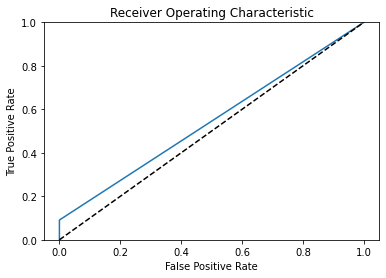

In [11]:
model_name = "custom_naive"

custom_naive_model = Sequential()

custom_naive_model.add(Embedding(vocab_size, 128, input_length=maxlen))
custom_naive_model.add(Flatten())
custom_naive_model.add(Dense(100))
custom_naive_model.add(Dense(1, activation='sigmoid'))

print(custom_naive_model.summary())
#plot_model(custom_naive_model, to_file=f'{model_name}.png', show_shapes=True)

train_NN(custom_naive_model, model_name)

print('------------------------------------------------------')

predictions = custom_naive_model.predict(X_test)
y_pred = np.where(predictions > 0.5, 1, 0).flatten()
evaluate_on_training_set(y_test, y_pred)

## LSTM

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(50, dropout=0.2, recurrent_dropout=0.2)`
  


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 128)         1009152   
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 1,045,003
Trainable params: 1,045,003
Non-trainable params: 0
_________________________________________________________________
None


/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 70 samples, validate on 18 samples
Epoch 1/30
70/70 [==============================] - 4s 64ms/step - loss: 0.6962 - accuracy: 0.4143 - val_loss: 0.6930 - val_accuracy: 0.5556
 — val_f1: 0.6666666666666666 — val_precision: 0.5714285714285714 — val_recall: 0.8
Epoch 2/30
70/70 [==============================] - 4s 56ms/step - loss: 0.6925 - accuracy: 0.5571 - val_loss: 0.6923 - val_accuracy: 0.5556
 — val_f1: 0.6666666666666666 — val_precision: 0.5714285714285714 — val_recall: 0.8
Epoch 3/30
70/70 [==============================] - 4s 57ms/step - loss: 0.6872 - accuracy: 0.6429 - val_loss: 0.6918 - val_accuracy: 0.5556
 — val_f1: 0.6666666666666666 — val_precision: 0.5714285714285714 — val_recall: 0.8
Epoch 4/30
70/70 [==============================] - 4s 56ms/step - loss: 0.6871 - accuracy: 0.6286 - val_loss: 0.6921 - val_accuracy: 0.5556
 — val_f1: 0.6666666666666666 — val_precision: 0.5714285714285714 — val_recall: 0.8
Epoch 5/30
70/70 [==============================] - 4s 5

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


70/70 [==============================] - 4s 59ms/step - loss: 0.6766 - accuracy: 0.5857 - val_loss: 0.6975 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 8/30
70/70 [==============================] - 4s 60ms/step - loss: 0.6713 - accuracy: 0.6429 - val_loss: 0.7007 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 9/30
70/70 [==============================] - 5s 68ms/step - loss: 0.6670 - accuracy: 0.6571 - val_loss: 0.7048 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 10/30
70/70 [==============================] - 5s 67ms/step - loss: 0.6567 - accuracy: 0.6571 - val_loss: 0.7107 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 11/30
70/70 [==============================] - 4s 61ms/step - loss: 0.6477 - accuracy: 0.6571 - val_loss: 0.7181 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 12/30
70/70 [===============

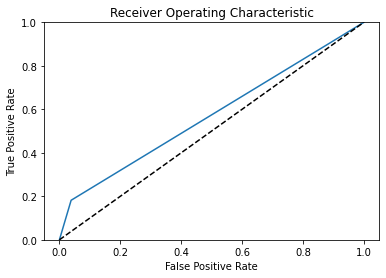

In [12]:
model_name = "custom_lstm"

custom_lstm_model = Sequential()

custom_lstm_model.add(Embedding(vocab_size, 128, input_length=maxlen, dropout=0.2))
custom_lstm_model.add(LSTM(50, dropout_U = 0.2, dropout_W = 0.2))
custom_lstm_model.add(Dense(1, bias_initializer=Constant(0.01), activation="sigmoid"))

print(custom_lstm_model.summary())
#plot_model(custom_lstm_model, to_file=f'{model_name}.png', show_shapes=True)

train_NN(custom_lstm_model, model_name)

print('------------------------------------------------------')

predictions = custom_lstm_model.predict(X_test)
y_pred = np.where(predictions > 0.5, 1, 0).flatten()
evaluate_on_training_set(y_test, y_pred)

# word2vec

In [13]:
if not Path('./GoogleNews-vectors-negative300.bin.gz').exists():
    !wget -P ./ "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [14]:
%%time

wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)
print('word2vec model loaded')

word2vec model loaded
CPU times: user 48.6 s, sys: 4.55 s, total: 53.2 s
Wall time: 53.5 s


In [15]:
wv_embedding_dim = 300

wv_embedding_matrix = np.zeros((len(word_index) + 1, wv_embedding_dim))
for word, i in word_index.items():
    if word in wv: 
        embedding_vector = wv[word]
        wv_embedding_matrix[i] = embedding_vector
        
wv_embedding_layer = Embedding(len(word_index) + 1, wv_embedding_dim, weights=[wv_embedding_matrix], 
                               input_length=maxlen, trainable=False)

## Naive Neural Networks

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 300)         2365200   
_________________________________________________________________
flatten_2 (Flatten)          (None, 300000)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30000100  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 32,365,401
Trainable params: 30,000,201
Non-trainable params: 2,365,200
_________________________________________________________________
None
Train on 70 samples, validate on 18 samples
Epoch 1/30
70/70 [==============================] - 0s 5ms/step - loss: 5.9877 - accuracy: 0.5429 - val_loss: 6.1871 - val_accuracy: 0.5556
 — val_f1: 0.7142857142857143 — val_precisi

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


70/70 [==============================] - 0s 1ms/step - loss: 2.3713e-06 - accuracy: 1.0000 - val_loss: 15.7220 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 8/30
70/70 [==============================] - 0s 2ms/step - loss: 1.8636e-06 - accuracy: 1.0000 - val_loss: 15.8057 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 9/30
70/70 [==============================] - 0s 1ms/step - loss: 1.6829e-06 - accuracy: 1.0000 - val_loss: 15.8683 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 10/30
70/70 [==============================] - 0s 1ms/step - loss: 1.5423e-06 - accuracy: 1.0000 - val_loss: 15.9152 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 11/30
70/70 [==============================] - 0s 398us/step - loss: 1.4793e-06 - accuracy: 1.0000 - val_loss: 15.9505 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 12/30


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


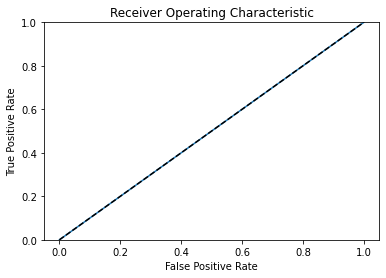

In [16]:
model_name = "word2vec_naive"

word2vec_naive_model = Sequential()

word2vec_naive_model.add(wv_embedding_layer)
word2vec_naive_model.add(Flatten())
word2vec_naive_model.add(Dense(100))
word2vec_naive_model.add(Dense(1, bias_initializer=Constant(0.01), activation="sigmoid"))

print(word2vec_naive_model.summary())
#plot_model(word2vec_naive_model, to_file=f'{model_name}.png', show_shapes=True)

train_NN(word2vec_naive_model, model_name)

print('------------------------------------------------------')

predictions = word2vec_naive_model.predict(X_test)
y_pred = np.where(predictions > 0.5, 1, 0).flatten()
evaluate_on_training_set(y_test, y_pred)

## LSTM 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 300)         2365200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 2,407,857
Trainable params: 42,657
Non-trainable params: 2,365,200
_________________________________________________________________
None
Train on 70 samples, validate on 18 samples
Epoch 1/30
70/70 [==============================] - 5s 70ms/step - loss: 0.6960 - accuracy: 0.4571 - val_loss: 0.6978 - val_accuracy: 0.3889
 — val_f1: 0.56 — val_precision: 0.4666666666666667 — val_recall: 0.7
Epoch 2/30
70/70 [==============================] - 6s 86ms/step - loss: 0.6928 - accuracy: 0.5286 - val_loss

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 14/30
70/70 [==============================] - 6s 85ms/step - loss: 0.6551 - accuracy: 0.6000 - val_loss: 0.7256 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 15/30
70/70 [==============================] - 5s 76ms/step - loss: 0.6593 - accuracy: 0.6000 - val_loss: 0.7311 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 16/30
70/70 [==============================] - 6s 84ms/step - loss: 0.6466 - accuracy: 0.6286 - val_loss: 0.7378 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 17/30
70/70 [==============================] - 6s 84ms/step - loss: 0.6282 - accuracy: 0.6286 - val_loss: 0.7370 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 18/30
70/70 [==============================] - 6s 83ms/step - loss: 0.6443 - accuracy: 0.6000 - val_loss: 0.7323 - val_accuracy: 0.4444
 — val_f1: 0.1666666

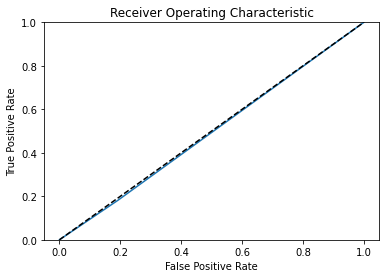

In [17]:
model_name = "word2vec_lstm"

word2vec_lstm_model = Sequential()
word2vec_lstm_model.add(wv_embedding_layer)
word2vec_lstm_model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.25))
word2vec_lstm_model.add(Dense(1, bias_initializer=Constant(0.01), activation="sigmoid"))

print(word2vec_lstm_model.summary())
#plot_model(word2vec_lstm_model, to_file=f'{model_name}.png', show_shapes=True)

train_NN(word2vec_lstm_model, model_name)

print('------------------------------------------------------')

predictions = word2vec_lstm_model.predict(X_test)
y_pred = np.where(predictions > 0.5, 1, 0).flatten()
evaluate_on_training_set(y_test, y_pred)

# GloVe

In [18]:
if not Path('./glove.twitter.27B.zip').exists():
    !wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
    !unzip glove*.zip

In [19]:
glove_embedding_index = {}
glove_embedding_dim = 100

f = open('glove.twitter.27B.100d.txt', encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:], dtype='float32')
    glove_embedding_index[word] = coeff

f.close()

In [20]:
glove_embedding_matrix = np.zeros((len(word_index) + 1, glove_embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_embedding_index.get(word)
    if embedding_vector is not None:
        glove_embedding_matrix[i] = embedding_vector

glove_embedding_layer = Embedding(len(word_index) + 1, glove_embedding_dim, weights=[glove_embedding_matrix], 
                                  input_length=maxlen, trainable=False)

## Naive Neural Network 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 100)         788400    
_________________________________________________________________
flatten_3 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10000100  
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 10,788,601
Trainable params: 10,000,201
Non-trainable params: 788,400
_________________________________________________________________
None
Train on 70 samples, validate on 18 samples
Epoch 1/30
70/70 [==============================] - 0s 2ms/step - loss: 14.5468 - accuracy: 0.5429 - val_loss: 24.8133 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_r

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 — val_f1: 0.6153846153846154 — val_precision: 0.5 — val_recall: 0.8
Epoch 3/30
70/70 [==============================] - 0s 238us/step - loss: 0.6170 - accuracy: 0.9714 - val_loss: 29.3778 - val_accuracy: 0.5556
 — val_f1: 0.7142857142857143 — val_precision: 0.5555555555555556 — val_recall: 1.0
Epoch 4/30
70/70 [==============================] - 0s 224us/step - loss: 0.7791 - accuracy: 0.9286 - val_loss: 23.6802 - val_accuracy: 0.5556
 — val_f1: 0.7142857142857143 — val_precision: 0.5555555555555556 — val_recall: 1.0
Epoch 5/30
70/70 [==============================] - 0s 195us/step - loss: 8.1934e-05 - accuracy: 1.0000 - val_loss: 18.3771 - val_accuracy: 0.5556
 — val_f1: 0.7142857142857143 — val_precision: 0.5555555555555556 — val_recall: 1.0
Epoch 6/30
70/70 [==============================] - 0s 219us/step - loss: 2.5374e-06 - accuracy: 1.0000 - val_loss: 14.6839 - val_accuracy: 0.5000
 — val_f1: 0.6666666666666667 — val_precision: 0.5294117647058824 — val_recall: 0.9
Epoch 7/30
70/7

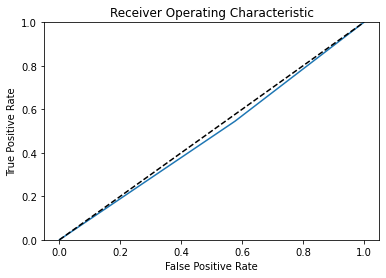

In [21]:
model_name = "glove_naive"

glove_naive_model = Sequential()

glove_naive_model.add(glove_embedding_layer)
glove_naive_model.add(Flatten())
glove_naive_model.add(Dense(100))
glove_naive_model.add(Dense(1, bias_initializer=Constant(0.01), activation="sigmoid"))

print(glove_naive_model.summary())
#plot_model(glove_naive_model, to_file=f'{model_name}.png', show_shapes=True)

train_NN(glove_naive_model, model_name)

print('------------------------------------------------------')

predictions = glove_naive_model.predict(X_test)
y_pred = np.where(predictions > 0.5, 1, 0).flatten()
evaluate_on_training_set(y_test, y_pred)

## LSTM

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 100)         788400    
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 805,457
Trainable params: 17,057
Non-trainable params: 788,400
_________________________________________________________________
None
Train on 70 samples, validate on 18 samples
Epoch 1/30
70/70 [==============================] - 4s 54ms/step - loss: 0.6951 - accuracy: 0.4857 - val_loss: 0.6864 - val_accuracy: 0.5000
 — val_f1: 0.608695652173913 — val_precision: 0.5384615384615384 — val_recall: 0.7
Epoch 2/30
70/70 [==============================] - 3s 47ms/step - loss: 0.6874 - accuracy: 0.5143 -

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


70/70 [==============================] - 3s 48ms/step - loss: 0.6753 - accuracy: 0.5857 - val_loss: 0.6873 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 7/30
70/70 [==============================] - 3s 48ms/step - loss: 0.6739 - accuracy: 0.5714 - val_loss: 0.6829 - val_accuracy: 0.5000
 — val_f1: 0.608695652173913 — val_precision: 0.5384615384615384 — val_recall: 0.7
Epoch 8/30
70/70 [==============================] - 3s 47ms/step - loss: 0.6697 - accuracy: 0.5714 - val_loss: 0.6776 - val_accuracy: 0.5556
 — val_f1: 0.6666666666666666 — val_precision: 0.5714285714285714 — val_recall: 0.8
Epoch 9/30
70/70 [==============================] - 3s 50ms/step - loss: 0.6472 - accuracy: 0.5857 - val_loss: 0.6784 - val_accuracy: 0.5556
 — val_f1: 0.6666666666666666 — val_precision: 0.5714285714285714 — val_recall: 0.8
Epoch 10/30
70/70 [==============================] - 4s 52ms/step - loss: 0.6695 - accuracy: 0.5857 - val_loss: 0.6812 - val_accuracy: 0.5000


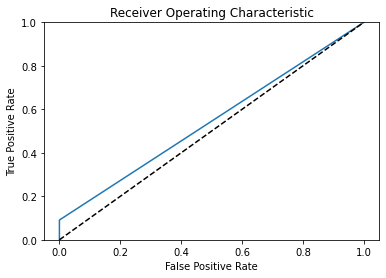

In [22]:
model_name = "glove_lstm"

glove_lstm_model = Sequential()
glove_lstm_model.add(glove_embedding_layer)
glove_lstm_model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.25))
glove_lstm_model.add(Dense(1, bias_initializer=Constant(0.01), activation="sigmoid"))

print(glove_lstm_model.summary())
#plot_model(glove_lstm_model, to_file=f'{model_name}.png', show_shapes=True)

train_NN(glove_lstm_model, model_name)

print('------------------------------------------------------')

predictions = glove_lstm_model.predict(X_test)
y_pred = np.where(predictions > 0.5, 1, 0).flatten()
evaluate_on_training_set(y_test, y_pred)